# Microtask 1
Produce a listing of the number of new committers per month, and the number of commits for each of them, as a table and as a CSV file. Use the GrimoireLab enriched index for git.

### Project Under Analysis: Chaoss

## Demonstrations

1. grimoirelab/full. The gitbook already had the code to accomplish it using p2o, so I have used a docker container for this task.
2. ElasticSearch with Grimoirelab enriched_index git
3. Pandas, for data analysis

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search

from pprint import pprint
import pandas as pd

from datetime import datetime

/home/utkarsh/anaconda3/lib/python3.6/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory: 'uname'
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


## Starter Code
Most of the starter code is available at the Tutorial gitbook. Most of the below code is simply a copy because our microtask can easily br=e executed with what was done in the gitbook.

We know when the first commit was made so we use that information to construct a "Group By" table grouping the first commits.

## Connecting to ES
The port 9200 needs to be exposed to ensure the connection is allowed. Ping checks if the connection was successful

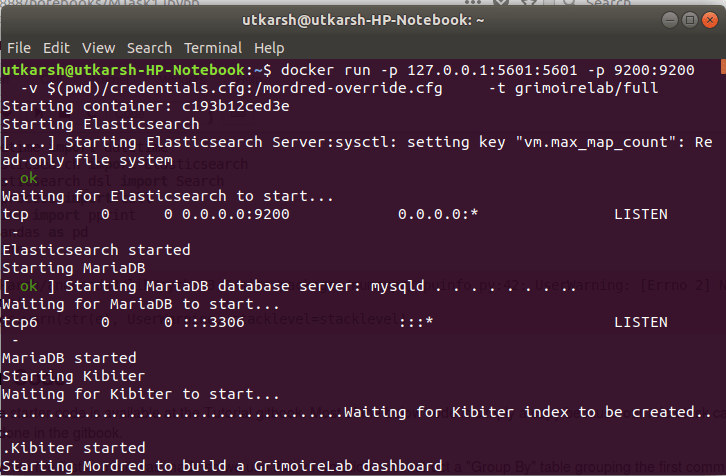

In [2]:
from IPython.display import Image
Image(filename ="/home/utkarsh/sc1.png")

In [3]:
es = Elasticsearch('http://localhost:9200', verify_certs=False)

In [4]:
es.ping()

True

In [5]:
s = Search(using=es, index='git')


In [6]:
s.aggs.bucket('by_authors', 'terms', field='author_name', size=10000).metric('first_commit', 'min', field='author_date')
s = s.sort("author_date")

In [7]:
result = s.execute()

In [8]:
buckets_result = result['aggregations']['by_authors']['buckets']
buckets = []
for bucket in buckets_result:
    first_commit = bucket['first_commit']['value']/1000
    buckets.append(
        {'first_commit': datetime.utcfromtimestamp(first_commit),
        'author': bucket['key'],
        'commit_count': bucket['doc_count']}
                )

In [9]:
people = pd.DataFrame.from_records(buckets)
people.sort_values(by='first_commit', ascending=False, inplace=True)

## Aggregating by month of commit

In [11]:
import calendar
monthly_new = pd.DataFrame(people['first_commit'].groupby([people.first_commit.dt.year,people.first_commit.dt.month.apply(lambda x: calendar.month_abbr[x])]).agg('count'))
monthly_new

first_commit
first_commit first_commit              
2014         Jun                      1
2015         Dec                      1
             Oct                      2
             Sep                      1
2016         Apr                      1
             Feb                      2
             Jan                      1
             Jul                      1
             Mar                      2
             Nov                      1
2017         Aug                      1
             Dec                      1
             Feb                      1
             Jan                      1
             Jun                      1
             Mar                      2
             Oct                      2
             Sep                      1
2018         Feb                      1
             Jan                      2
             Mar                      1

In [12]:
monthly_new.to_csv('montly_new')